In [1]:
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle
import tensorflow as tf
from scipy.special import expit

from misc_modules import dm_test, plot_double_standard
# from models_return import plot_double_standard, get_bi_lstm_model,get_cnn_lstm_model,get_cnn_model,sequences,train_model,train_parallel
from sklearn.model_selection import train_test_split
from scipy.special import expit
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

from keras.layers import LSTM, Dense, Bidirectional, Flatten, TimeDistributed
from tensorflow.keras.optimizers import Adam

2024-09-05 07:42:52.259689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 07:42:52.298925: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 07:42:52.311388: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-05 07:42:52.384847: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-05 07:42:53.263641: W tensorflow/com

In [2]:
etfs = ['ICLN', 'PBD' , 'QCLN']
lags = [1,3,5]
predType = 'ahead_Return'
predLabel = 'Log-Return'
pred_size=250
model_name = f'cnnlstm-{predType}'

save_path = '../../results'
data_path = '../../data'

sent_dict = {
    'SENT': ['log_ovx', 'log_return', 'log_navR', 'GT_VAL_SENT', 'INV_VAL_SENT','d1-inv','d2-gt'],
    'NO_SENT': ['log_ovx', 'log_return', 'log_navR']
}

In [3]:
def fetch(file,lag):
    data = pd.read_csv(f"{data_path}/{file}/{file}_INPUT.csv")
    data['ahead_Return'] = data['log_return'].shift(-1*(lag))
    data['ahead_vol'] = data['Garchvol'].shift(-1*(lag))
    data = data[:-1*(lag)]
    data.reset_index(drop=True,inplace=True)
    return data

def sequences(X,y,timesteps) :
    X = np.asarray(X)
    y = np.asarray(y)
    alpha = []
    beta = []
    n = timesteps
    for i in range(X.shape[0]):
        if i < n-1 :
            continue
        alpha.append(X[i-(n-1):i+1])
        beta.append(y[i])

    return np.asarray(alpha),np.asarray(beta)

def root_mean_squared_loss(y_true,y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def calc_rmse(actual, pred) : 
    return np.sqrt(mean_squared_error(np.asarray(actual).reshape(-1), np.asarray(pred).reshape(-1)))

def percentage_change(sent_rmse, rmse): 
    return ((sent_rmse-rmse)/rmse)

def concat_results_and_mean(arrays):
    new_arrays = [np.array(single_arr).reshape(-1) for single_arr in arrays]
    mean_array = np.mean(new_arrays, axis=0)
    return mean_array

In [4]:
def model(input_shape):
    def cnn_lstm_model(input_shape,kernel_size=1):
        (Timesteps,No_Features) = input_shape
        model = Sequential()
        model.add(Conv1D(filters=32, kernel_size=kernel_size, activation='relu', input_shape=(Timesteps,No_Features)))
        model.add(MaxPooling1D(pool_size=1))
        
        model.add(LSTM(32, activation='relu'))  # Use LSTM layer
        model.add(Flatten())
        model.add(Dense(8))
        model.add(Dense(1)) 

        model.compile(optimizer='adam', loss=root_mean_squared_loss, metrics=['mae'])
        model.summary()
        return model
    

    return cnn_lstm_model(input_shape)


In [5]:
def make_res(y_preds_a, y_preds_b , y_actual, date, etf, lag) :

    y_preds_a = y_preds_a.reshape(-1)
    y_preds_b = y_preds_b.reshape(-1)
    y_actual = y_actual.reshape(-1)
    actual = y_actual
    
    res_df = pd.DataFrame()
    res_df['Date'] = pd.to_datetime(date)
    res_df['actual'] = np.asarray(y_actual).reshape(-1)
    res_df[f"sent"] = y_preds_a.reshape(-1)
    res_df[f"no-sent"] = y_preds_b.reshape(-1)

    img_path = f'{save_path}/images/{model_name}-{etf}-{lag}.png'
    df_path = f'{save_path}/predictions/{model_name}-{etf}-{lag}.csv'

    plot_double_standard(
        Model   = model_name,
        date    = res_df.Date,
        actual  = res_df.actual,
        sent    = y_preds_a.reshape(-1),
        no_sent = y_preds_b.reshape(-1),
        save_at = img_path
    )

    res_df.to_csv(df_path,index=False)
    
    sent_rmse = calc_rmse(actual,y_preds_a.reshape(-1))
    no_sent_rmse = calc_rmse(actual,y_preds_b.reshape(-1))
    pc = percentage_change(sent_rmse,no_sent_rmse)
    dmvalMSE = dm_test(actual_lst=actual,pred1_lst=y_preds_a,pred2_lst=y_preds_b,h=lag, crit="MSE")

    output_path = f'{save_path}/output.csv'
    try:
        output = pd.read_csv(output_path)
    except :
        output = pd.DataFrame(columns=['file','Model', 'shift',"RMSE SENT",'RMSE','pc','DM MSE', 'p_value MSE' ])

    newrow = {}
    newrow['file'] = etf
    newrow['Model'] = f"{model_name}"
    newrow['shift'] = lag
    newrow[f'RMSE SENT'] = sent_rmse
    newrow[f'RMSE'] = no_sent_rmse
    newrow[f'pc'] = pc

    newrow['DM MSE'] = dmvalMSE['DM']
    newrow['p_value MSE'] = dmvalMSE['p_value']
    
    print(newrow)

    exist = output.index[(output['file'] == newrow['file']) & (output['Model'] == newrow['Model']) & (output['shift'] == newrow['shift'])]

    if len(exist):
        output.loc[exist[0]] = newrow
    else:
        output.loc[len(output)] = newrow

    output.to_csv(output_path,index=False)   

def sliding_window_train(model,X ,Y , train_window=500, test_window = 10,  pred_size=pred_size,sequence_size=4) :

    result = []

    # .reshape(X[:-pred_size].shape[0],1,sequence_size,-1)
    model.fit(X[:-pred_size], Y[:-pred_size], epochs=200, verbose=False)

    # tw_start and tw_end , means training window start index and end index
    for tw_end in range(X.shape[0] - pred_size, X.shape[0], 10):
        tw_start = tw_end - train_window

        X_train, y_train = X[tw_start:tw_end], Y[tw_start:tw_end]
        # X_train = X_train.reshape(X_train.shape[0],1,sequence_size,-1)
        model.fit(X_train, y_train, epochs=50, verbose=0)

        test = X[tw_end:tw_end+test_window]  #.reshape(X[tw_end:tw_end+test_window].shape[0],1,sequence_size,-1)
        preds = model.predict(test, verbose=False)
        result.extend(preds)
        print(tw_end, end=' ')
 
    rmse_val = root_mean_squared_loss(Y[-pred_size:].reshape(-1), np.array(result).reshape(-1))

    print(f"model RMSE = {rmse_val}")

    return np.array(result), model

In [6]:


def generate_result(
        etf,
        lag,
        sent_cols = sent_dict['SENT'],
        no_sent_cols = sent_dict['NO_SENT'],
        predType = predType,
        cross_window = 10,
        sequence_size = 4 # using past 4 sequences to predict next sequence
    ) :

    data = fetch(etf,lag)

    SENT_X = data[sent_cols]
    SENT_Y = data[[predType]]
    NO_SENTX = data[no_sent_cols]
    NO_SENTY = data[[predType]]

    SENT_X,SENT_Y = sequences(SENT_X,SENT_Y,timesteps=sequence_size)
    NO_SENT_X,NO_SENT_Y = sequences(NO_SENTX,NO_SENTY,timesteps=sequence_size)

    
    sent_model = model(input_shape=SENT_X.shape[1:])
    no_sent_model = model(input_shape=NO_SENT_X.shape[1:])
    sent_predictions = []
    no_sent_predictions = []
    mean_sent, mean_no_sent = None , None
    for k in range(cross_window) :

        print(k,end=' : ')
        sent_res,sent_model = sliding_window_train(model=sent_model,X=SENT_X,Y=SENT_Y,sequence_size=sequence_size)
        no_sent_res,no_sent_model = sliding_window_train(model=no_sent_model,X=NO_SENT_X,Y=NO_SENT_Y,sequence_size=sequence_size)

        sent_predictions.append(sent_res)
        no_sent_predictions.append(no_sent_res)

        mean_sent = concat_results_and_mean(sent_predictions)
        mean_no_sent = concat_results_and_mean(no_sent_predictions)

    make_res(
        y_preds_a = mean_sent,
        y_preds_b = mean_no_sent ,
        y_actual = SENT_Y[-pred_size:], 
        date = data['Date'][-pred_size:] , 
        etf=etf, 
        lag=lag
    )

        

/home/kali/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1725502374.203889     439 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725502374.298793     439 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725502374.298834     439 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725502374.301601     439 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4, 32)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,849 (34.57 KB)

 Trainable params: 8,849 (34.57 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 4, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,721 (34.07 KB)

 Trainable params: 8,721 (34.07 KB)

 Non-trainable params: 0 (0.00 B)

0 : 

I0000 00:00:1725502376.193468     582 service.cc:146] XLA service 0x7fcbf000c210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725502376.193502     582 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2024-09-05 07:42:56.221456: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-05 07:42:56.364801: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1725502377.234462     582 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1234 1244 1254 1264 1274 1284 1294 1304 1314 1324 1334 1344 1354 1364 1374 1384 1394 1404 1414 1424 1434 1444 1454 1464 1474 model RMSE = 0.01548154923489123
1234 1244 1254 1264 1274 1284 1294 1304 1314 1324 1334 1344 1354 1364 1374 1384 1394 1404 1414 1424 1434 1444 1454 1464 1474 model RMSE = 0.013380404522825063
1 : 1234 1244 1254 1264 1274 1284 1294 1304 1314 1324 1334 1344 1354 1364 1374 1384 1394 1404 1414 1424 1434 1444 1454 1464 1474 model RMSE = 0.011728511872198037
1234 1244 1254 1264 1274 1284 1294 1304 1314 1324 1334 1344 1354 1364 1374 1384 1394 1404 1414 1424 1434 1444 1454 1464 1474 model RMSE = 0.01306332904915859
2 : 1234 1244 1254 1264 1274 1284 1294 1304 1314 1324 1334 1344 1354 1364 1374 1384 1394 1404 1414 1424 1434 1444 1454 1464 1474 model RMSE = 0.009764594329021822
1234 1244 1254 1264 1274 1284 1294 1304 1314 1324 1334 1344 1354 1364 1374 1384 1394 1404 1414 1424 1434 1444 1454 1464 1474 model RMSE = 0.013900204921609377
3 : 1234 1244 1254 1264 1274 1284 1294 1

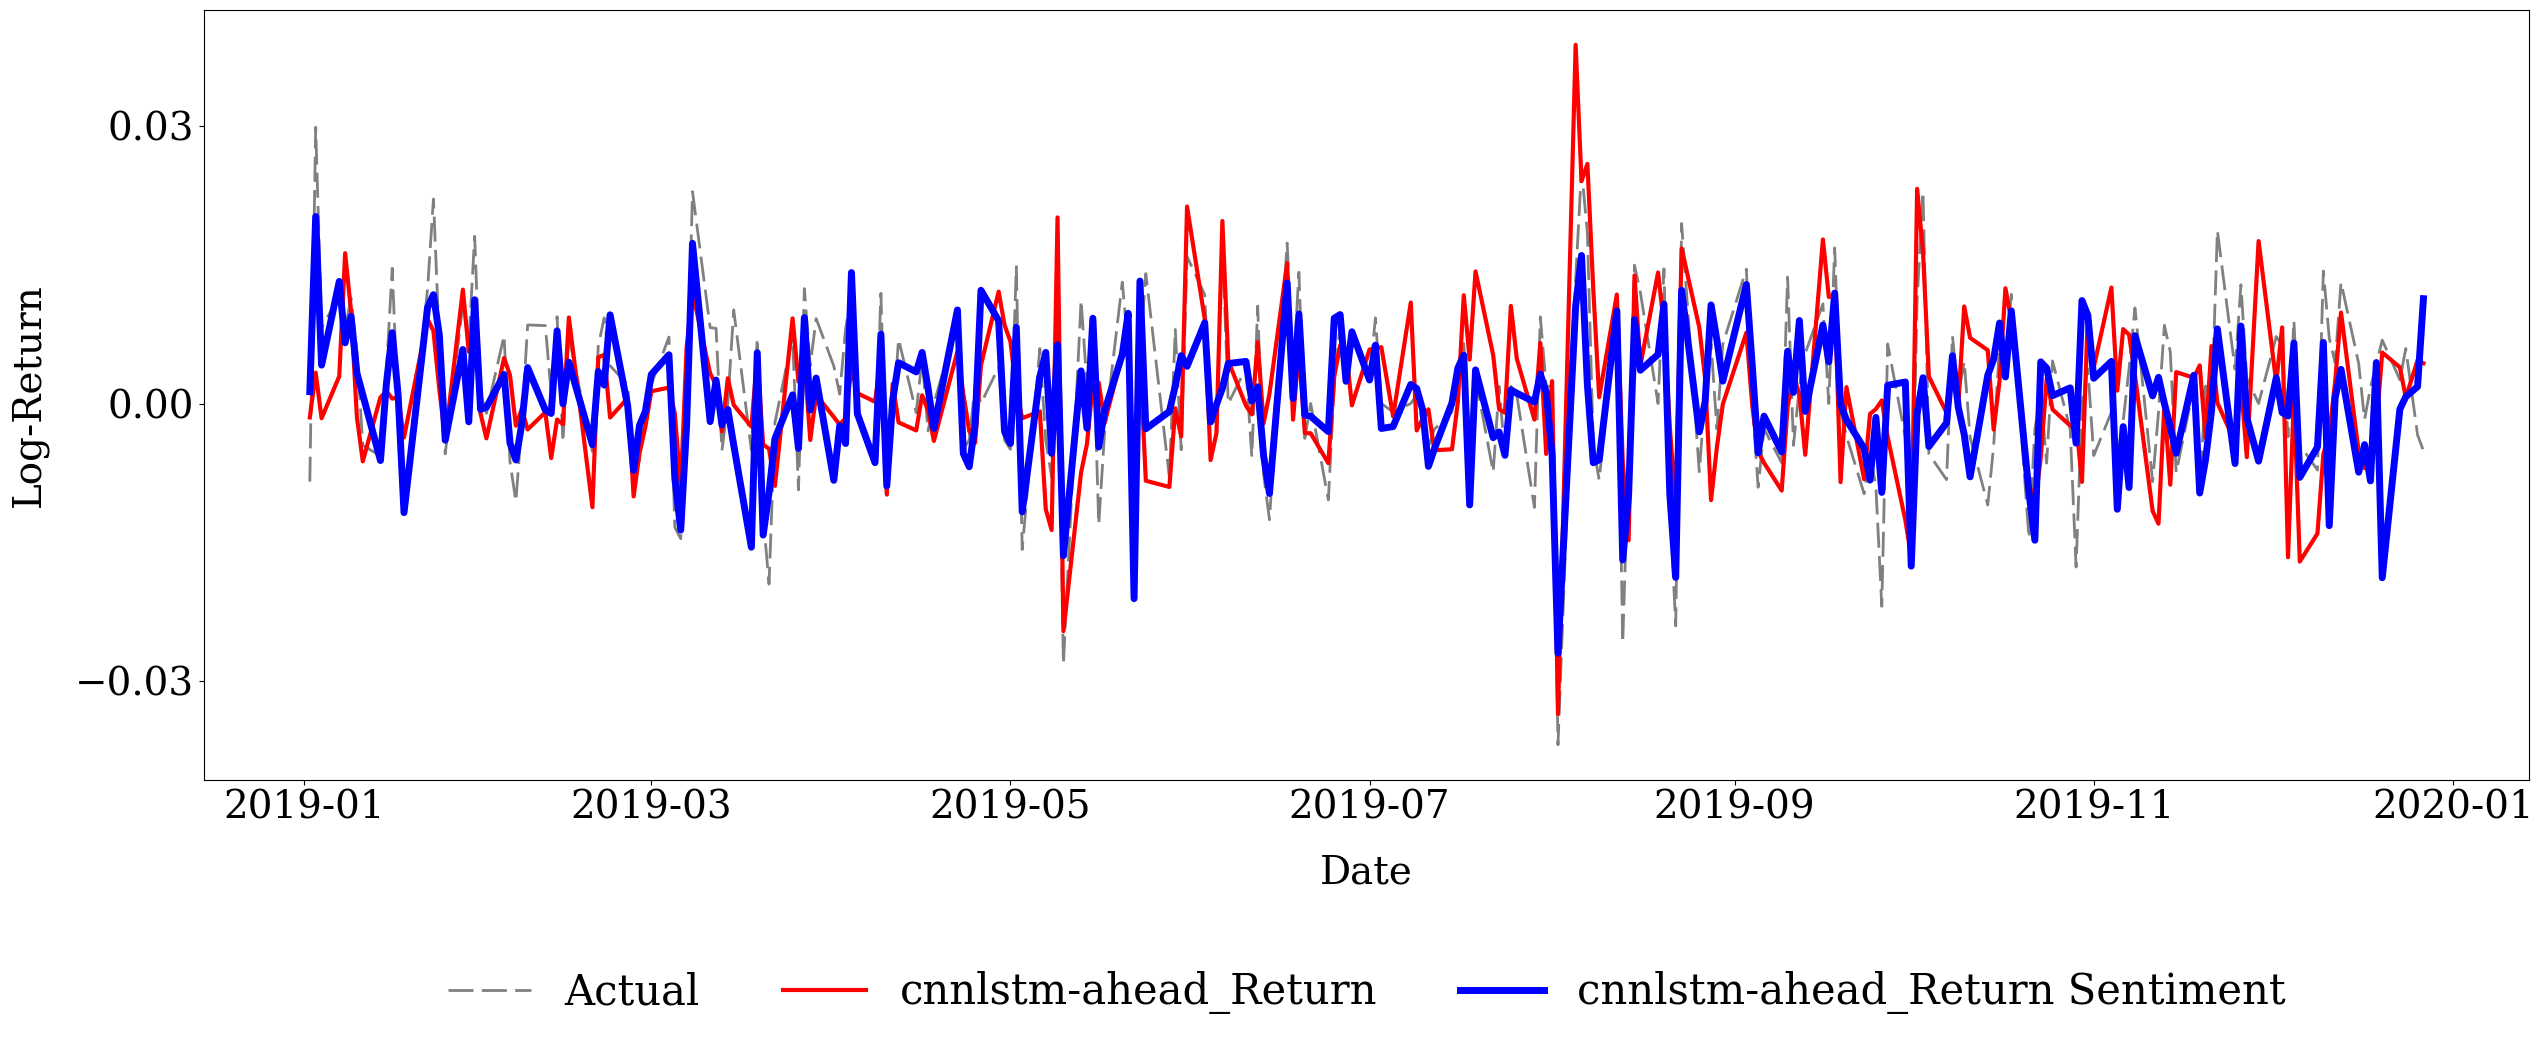

{'file': 'ICLN', 'Model': 'cnnlstm-ahead_Return', 'shift': 1, 'RMSE SENT': 0.00643354080581724, 'RMSE': 0.008282670882992109, 'pc': -0.22325287377673422, 'DM MSE': -3.818085451401879, 'p_value MSE': 0.0001698123333173643}


/home/kali/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 4, 32)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,849 (34.57 KB)

 Trainable params: 8,849 (34.57 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 4, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,721 (34.07 KB)

 Trainable params: 8,721 (34.07 KB)

 Non-trainable params: 0 (0.00 B)

0 : 1234 1244 1254 1264 1274 1284 1294 1304 1314 1324 1334 1344 1354 1364 1374 1384 1394 1404 1414 1424 1434 1444 1454 1464 1474 model RMSE = 0.016785717152940693
1234 1244 1254 1264 1274 1284 1294 1304 1314 1324 1334 1344 1354 1364 1374 1384 1394 1404 1414 1424 1434 1444 1454 1464 1474 model RMSE = 0.011476245296562583
1 : 1234 1244 1254 1264 1274 1284 1294 1304 1314 1324 1334 1344 1354 1364 1374 1384 1394 1404 1414 1424 1434 1444 1454 1464 1474 model RMSE = 0.011020342789879654
1234 1244 1254 1264 1274 1284 1294 1304 1314 1324 1334 1344 1354 1364 1374 1384 1394 1404 1414 1424 1434 1444 1454 1464 1474 model RMSE = 0.009846382240319185
2 : 1234 1244 1254 1264 1274 1284 1294 1304 1314 1324 1334 1344 1354 1364 1374 1384 1394 1404 1414 1424 1434 1444 1454 1464 1474 model RMSE = 0.008295287383099977
1234 1244 1254 1264 1274 1284 1294 1304 1314 1324 1334 1344 1354 1364 1374 1384 1394 1404 1414 1424 1434 1444 1454 1464 1474 model RMSE = 0.008140420069395107
3 : 1234 1244 1254 1264 1274 1284 

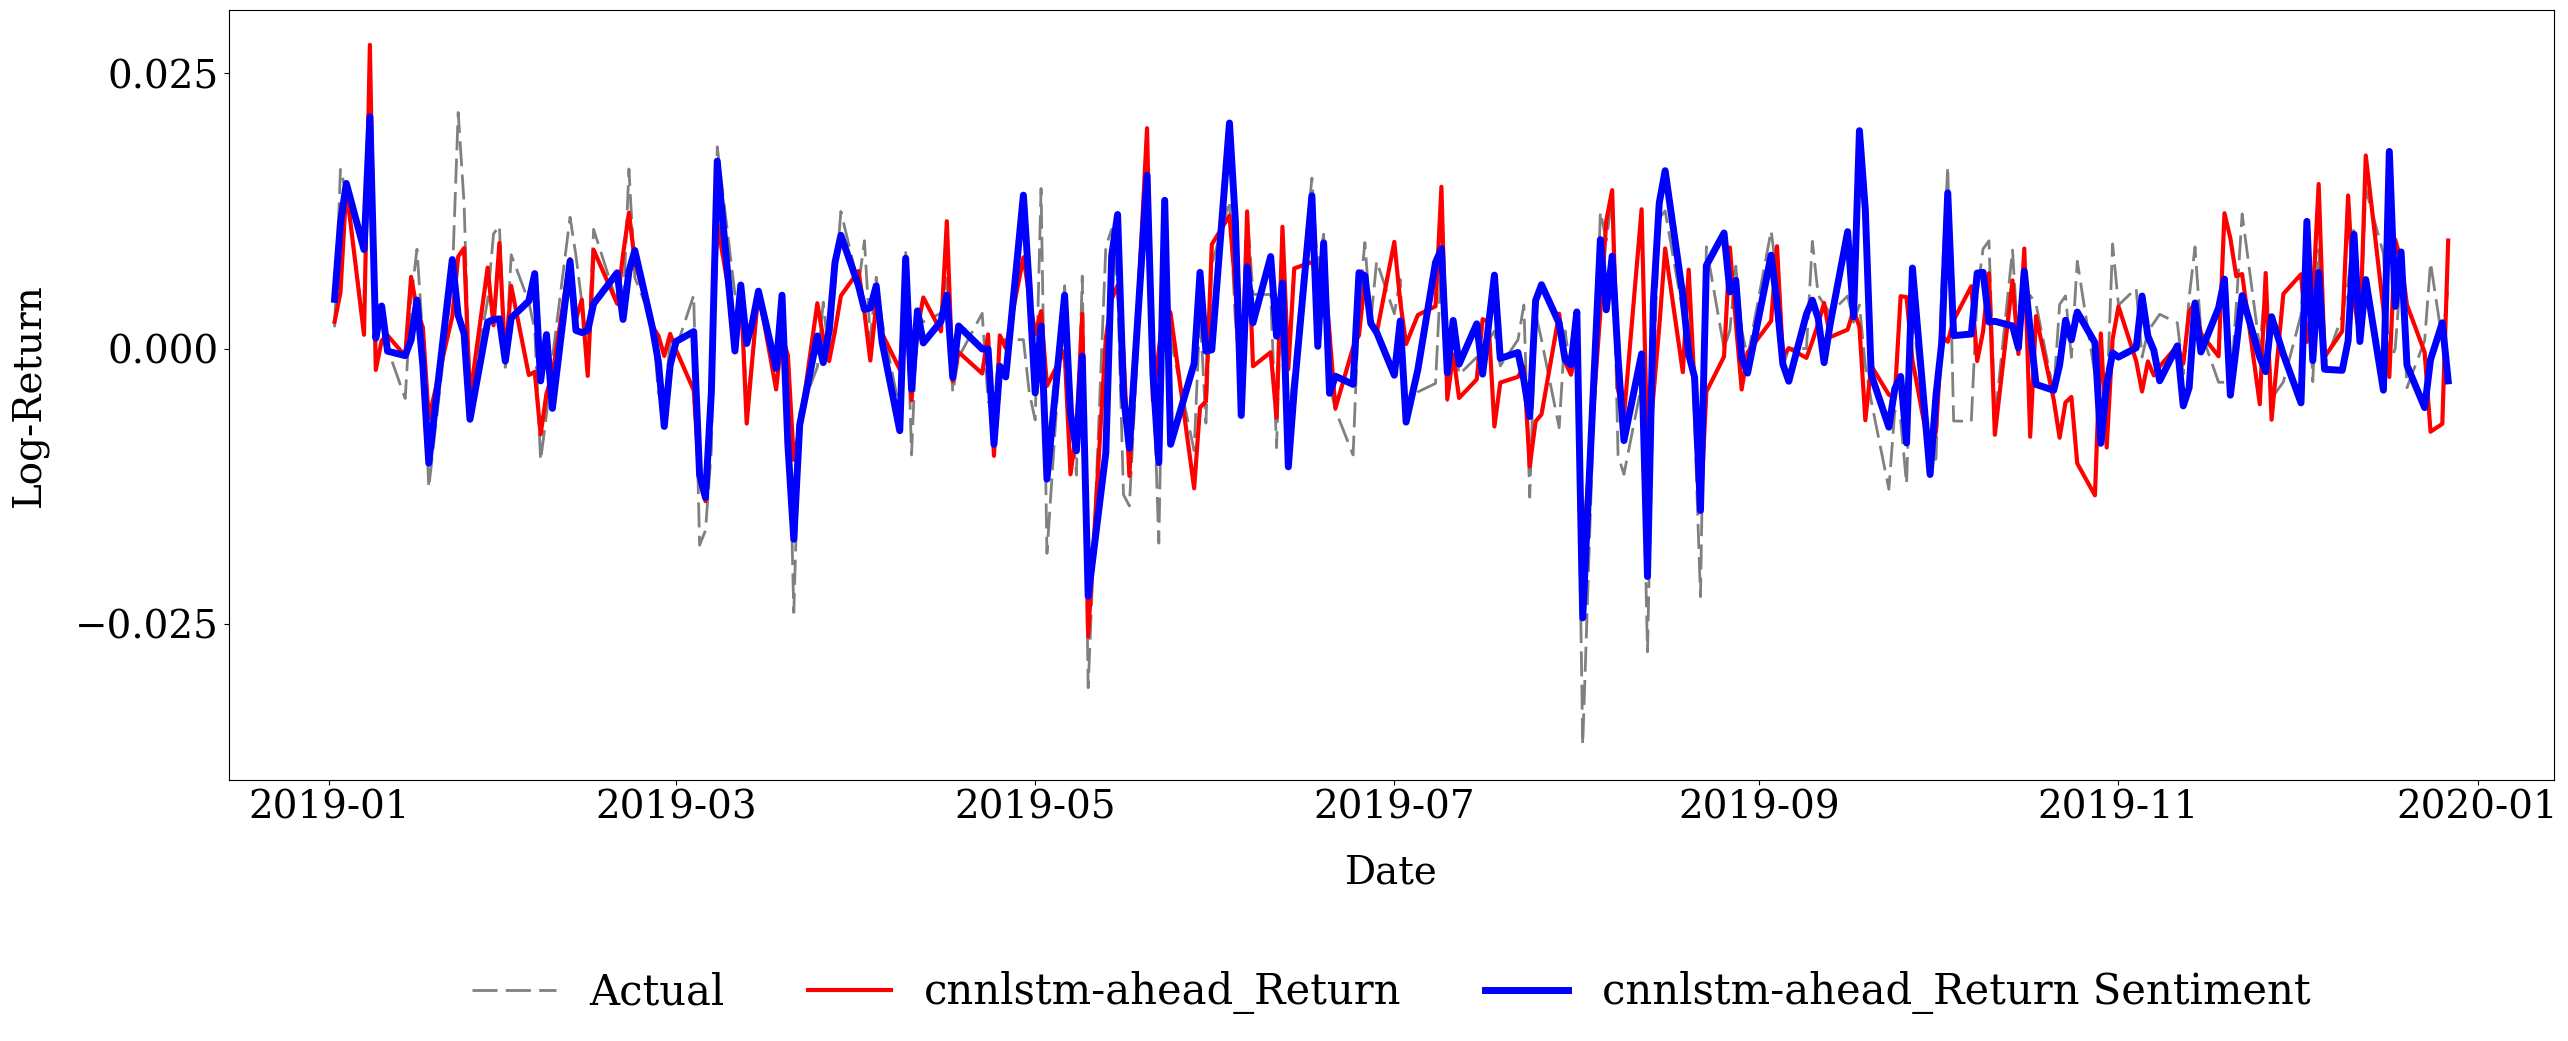

{'file': 'PBD', 'Model': 'cnnlstm-ahead_Return', 'shift': 1, 'RMSE SENT': 0.005508840223406378, 'RMSE': 0.006157329622463107, 'pc': -0.10531990957426035, 'DM MSE': -1.6139023033504158, 'p_value MSE': 0.1078151369504105}


/home/kali/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 4, 32)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,849 (34.57 KB)

 Trainable params: 8,849 (34.57 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 4, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,721 (34.07 KB)

 Trainable params: 8,721 (34.07 KB)

 Non-trainable params: 0 (0.00 B)

0 : 1234 1244 1254 1264 1274 1284 1294 1304 1314 1324 1334 1344 1354 1364 1374 1384 1394 1404 1414 1424 1434 1444 1454 1464 1474 model RMSE = 0.019915201488728173
1234 1244 1254 1264 1274 1284 1294 1304 1314 1324 1334 1344 1354 1364 1374 1384 1394 1404 1414 1424 1434 1444 1454 1464 1474 model RMSE = 0.019769269092479645
1 : 1234 1244 1254 1264 1274 1284 1294 1304 1314 1324 1334 1344 1354 1364 1374 1384 1394 1404 1414 1424 1434 1444 1454 1464 1474 model RMSE = 0.014890033583433568
1234 1244 1254 1264 1274 1284 1294 1304 1314 1324 1334 1344 1354 1364 1374 1384 1394 1404 1414 1424 1434 1444 1454 1464 1474 model RMSE = 0.016396351462901013
2 : 1234 1244 1254 1264 1274 1284 1294 1304 1314 1324 1334 1344 1354 1364 1374 1384 1394 1404 1414 1424 1434 1444 1454 1464 1474 model RMSE = 0.011496746484430382
1234 1244 1254 1264 1274 1284 1294 1304 1314 1324 1334 1344 1354 1364 1374 1384 1394 1404 1414 1424 1434 1444 1454 1464 1474 model RMSE = 0.014509720919766819
3 : 1234 1244 1254 1264 1274 1284 

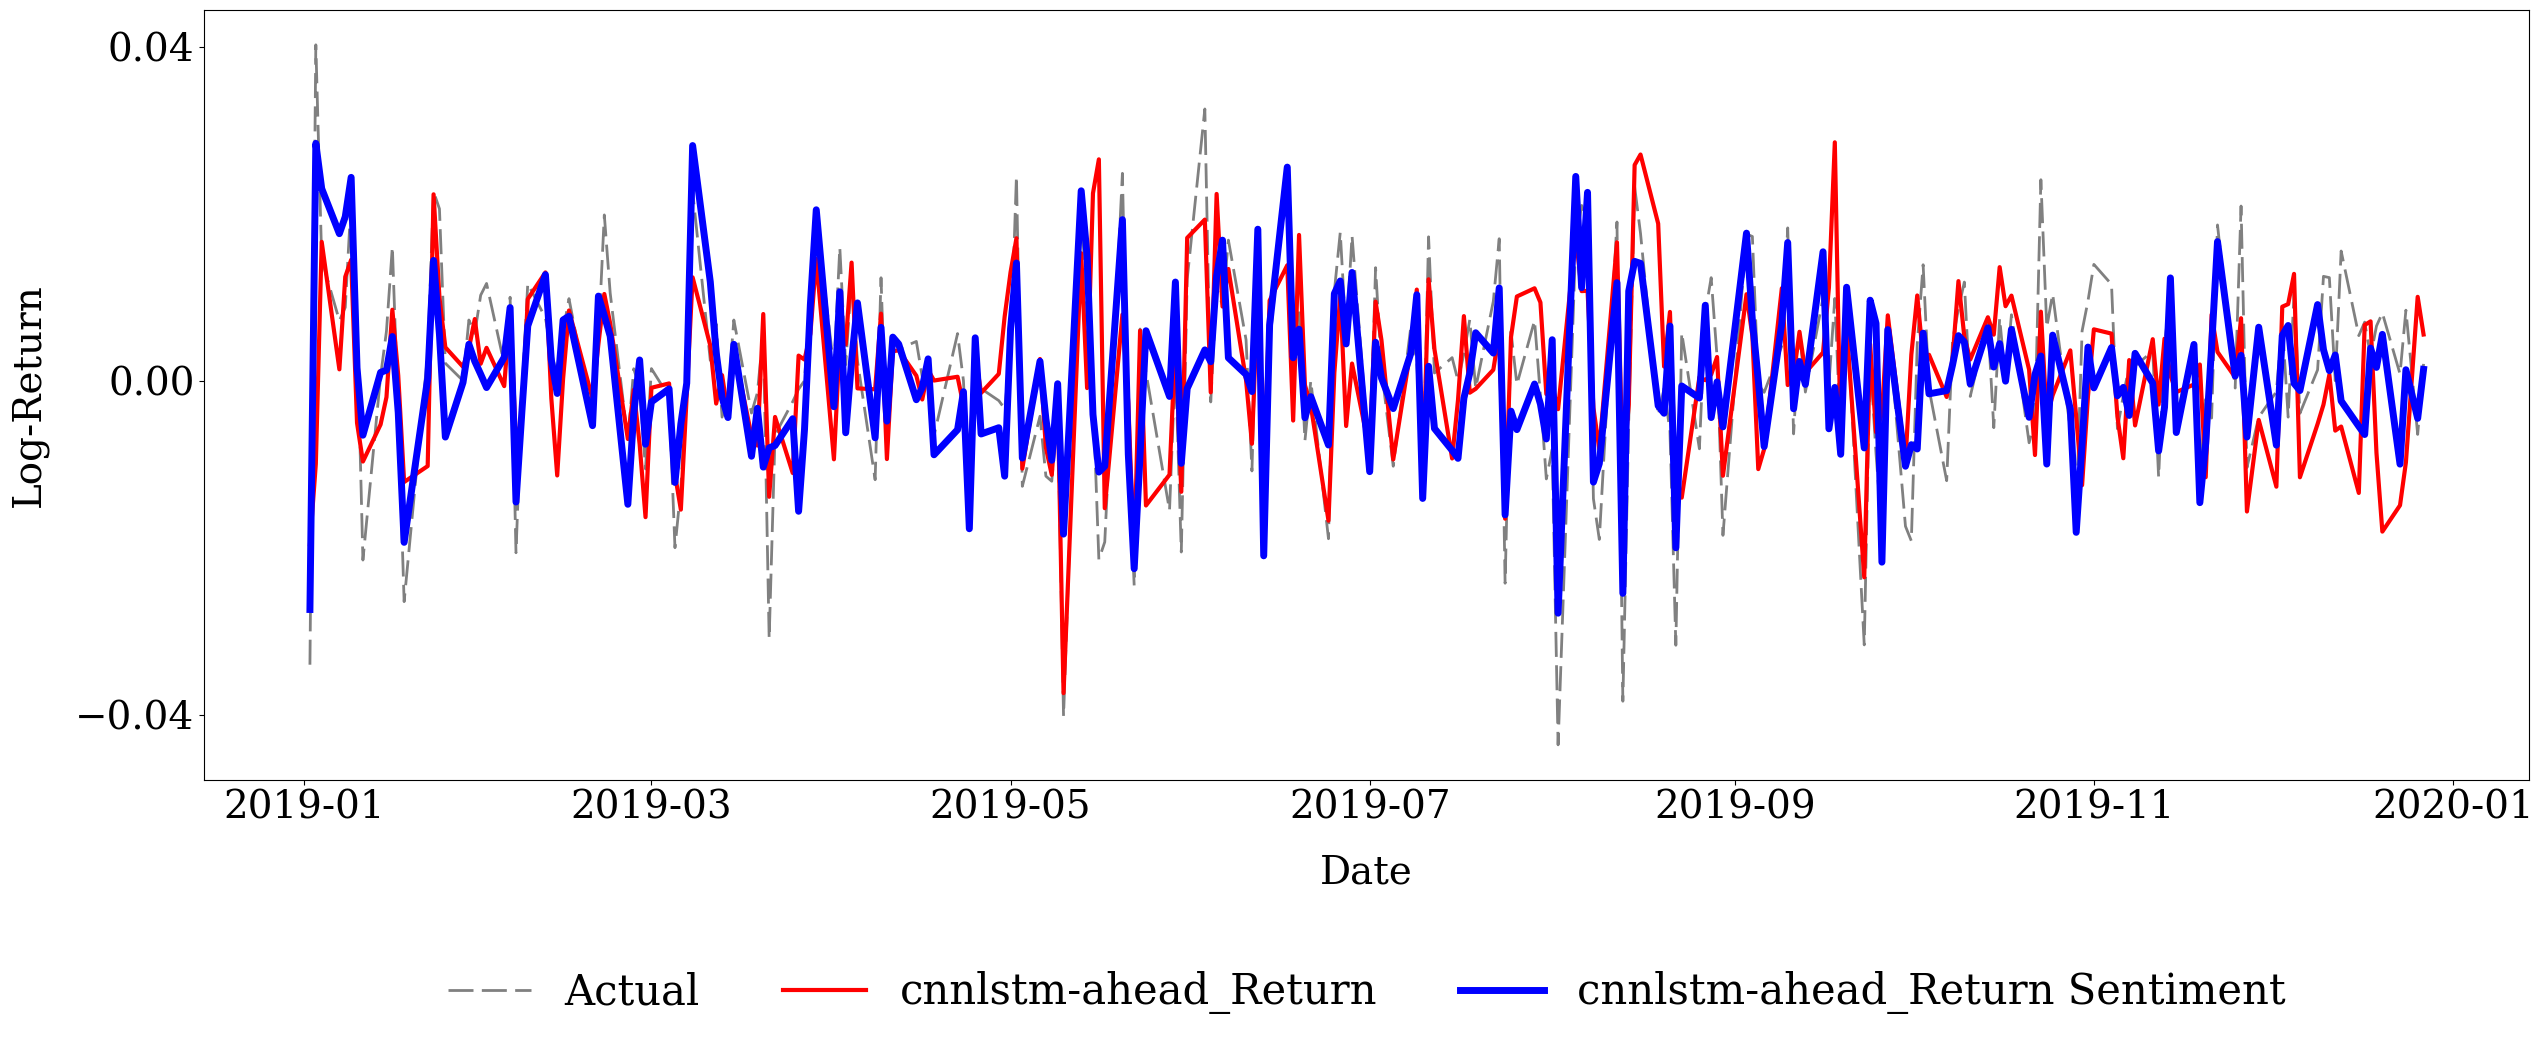

{'file': 'QCLN', 'Model': 'cnnlstm-ahead_Return', 'shift': 1, 'RMSE SENT': 0.007934013347578763, 'RMSE': 0.010160746014991926, 'pc': -0.21915050963065852, 'DM MSE': -2.459099877337337, 'p_value MSE': 0.014609594915208272}


/home/kali/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 4, 32)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,849 (34.57 KB)

 Trainable params: 8,849 (34.57 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)               │ (None, 4, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,721 (34.07 KB)

 Trainable params: 8,721 (34.07 KB)

 Non-trainable params: 0 (0.00 B)

0 : 1232 1242 1252 1262 1272 1282 1292 1302 1312 1322 1332 1342 1352 1362 1372 1382 1392 1402 1412 1422 1432 1442 1452 1462 1472 model RMSE = 0.015540453833737247
1232 1242 1252 1262 1272 1282 1292 1302 1312 1322 1332 1342 1352 1362 1372 1382 1392 1402 1412 1422 1432 1442 1452 1462 1472 model RMSE = 0.01300818844482306
1 : 1232 1242 1252 1262 1272 1282 1292 1302 1312 1322 1332 1342 1352 1362 1372 1382 1392 1402 1412 1422 1432 1442 1452 1462 1472 model RMSE = 0.014586433615089952
1232 1242 1252 1262 1272 1282 1292 1302 1312 1322 1332 1342 1352 1362 1372 1382 1392 1402 1412 1422 1432 1442 1452 1462 1472 model RMSE = 0.012688229811198153
2 : 1232 1242 1252 1262 1272 1282 1292 1302 1312 1322 1332 1342 1352 1362 1372 1382 1392 1402 1412 1422 1432 1442 1452 1462 1472 model RMSE = 0.010255820522247343
1232 1242 1252 1262 1272 1282 1292 1302 1312 1322 1332 1342 1352 1362 1372 1382 1392 1402 1412 1422 1432 1442 1452 1462 1472 model RMSE = 0.014968245866746117
3 : 1232 1242 1252 1262 1272 1282 1

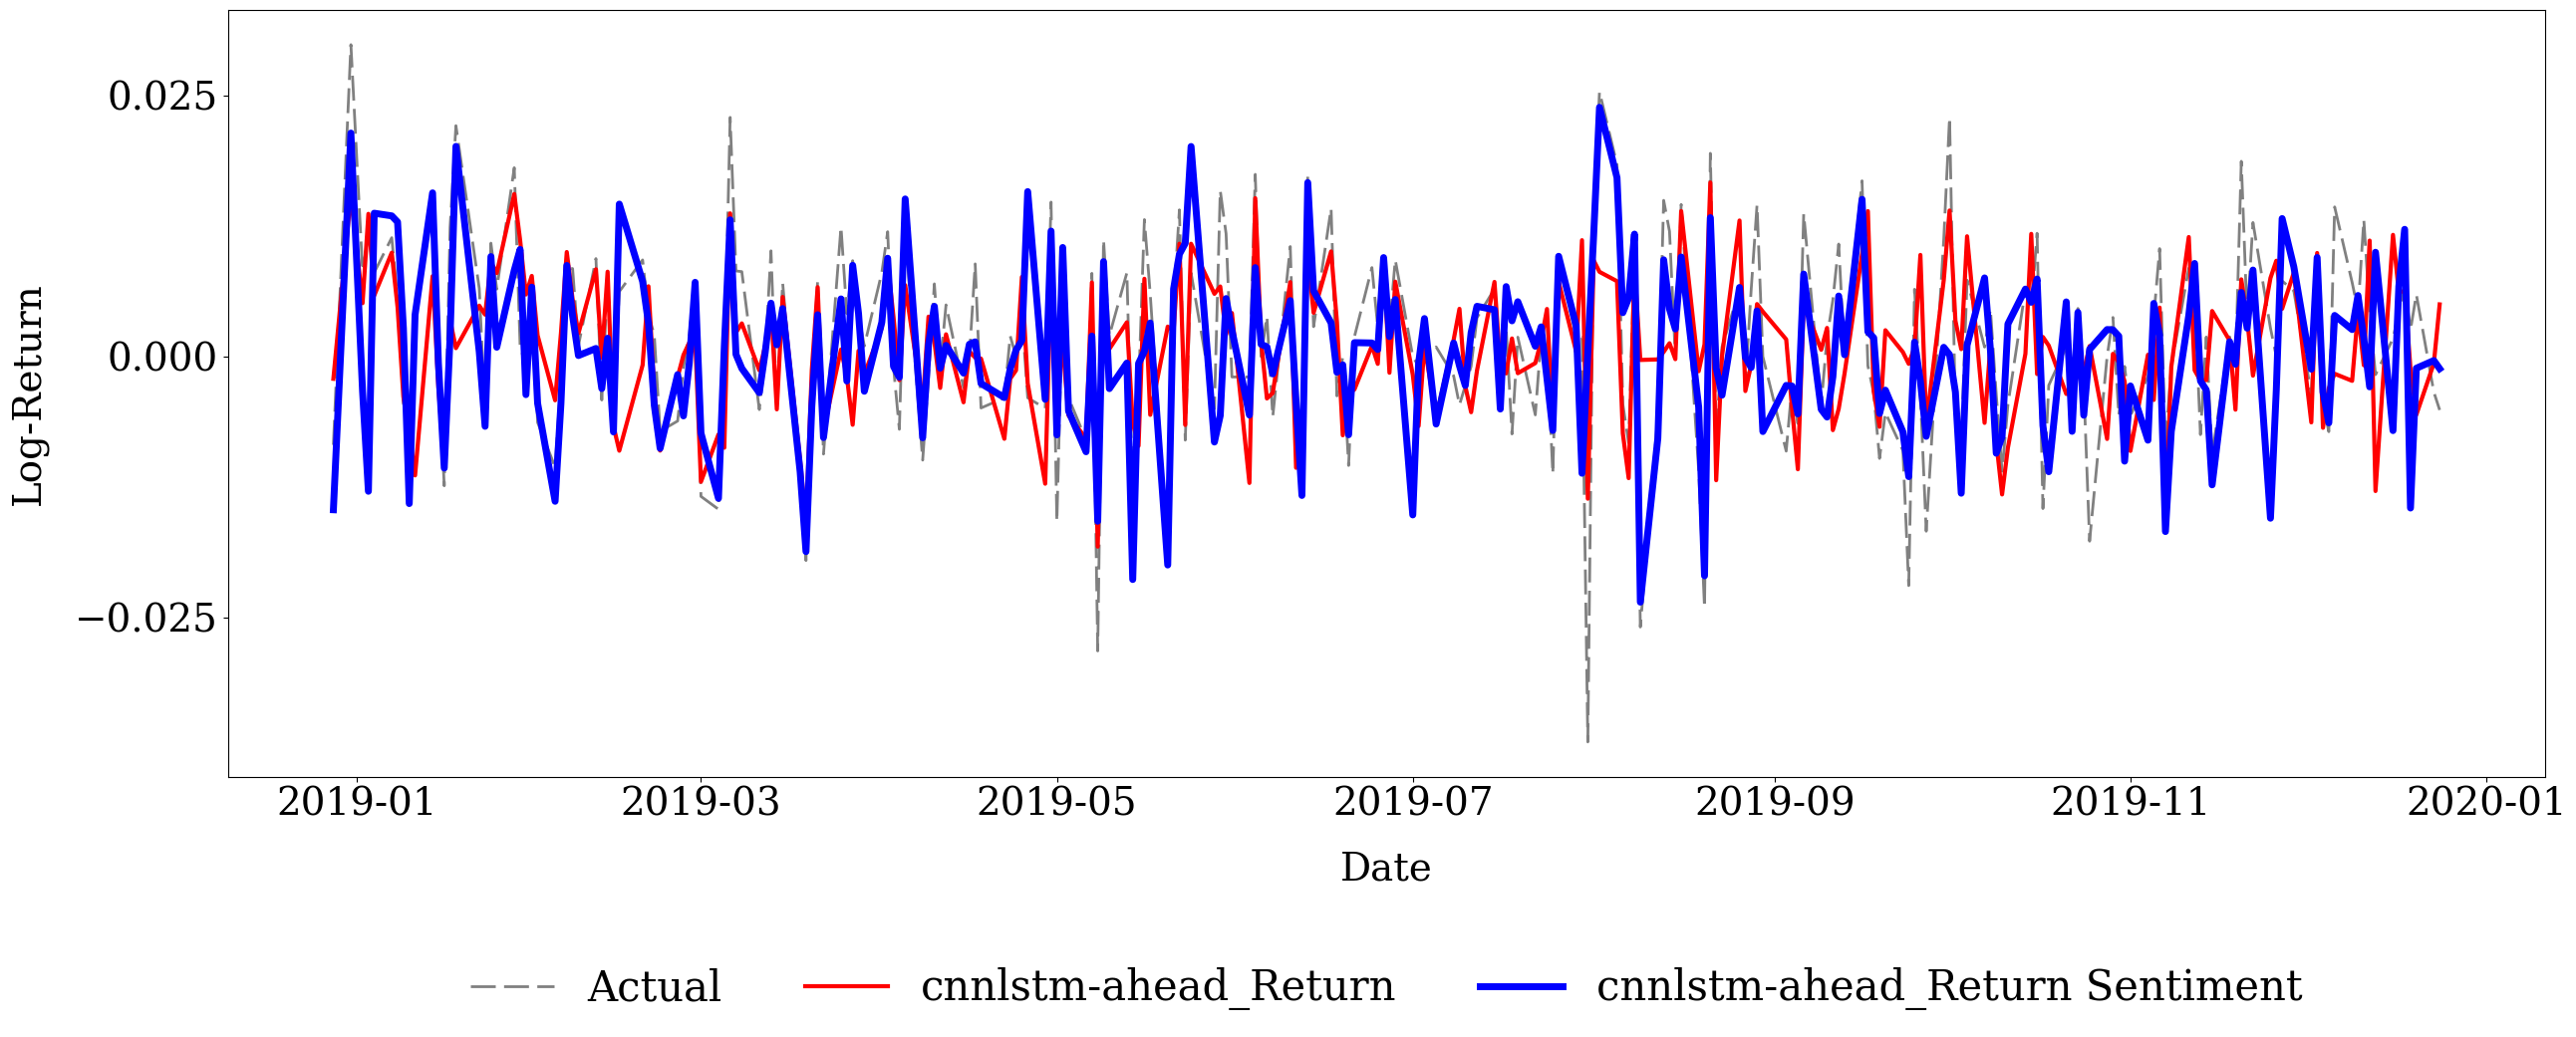

{'file': 'ICLN', 'Model': 'cnnlstm-ahead_Return', 'shift': 3, 'RMSE SENT': 0.0068086603951808084, 'RMSE': 0.007493435205242326, 'pc': -0.0913832963528472, 'DM MSE': -1.231429959663769, 'p_value MSE': 0.21932386262362819}


/home/kali/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 4, 32)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,849 (34.57 KB)

 Trainable params: 8,849 (34.57 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 4, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,721 (34.07 KB)

 Trainable params: 8,721 (34.07 KB)

 Non-trainable params: 0 (0.00 B)

0 : 1232 1242 1252 1262 1272 1282 1292 1302 1312 1322 1332 1342 1352 1362 1372 1382 1392 1402 1412 1422 1432 1442 1452 1462 1472 model RMSE = 0.015859845078006106
1232 1242 1252 1262 1272 1282 1292 1302 1312 1322 1332 1342 1352 1362 1372 1382 1392 1402 1412 1422 1432 1442 1452 1462 1472 model RMSE = 0.013076868665203571
1 : 1232 1242 1252 1262 1272 1282 1292 1302 1312 1322 1332 1342 1352 1362 1372 1382 1392 1402 1412 1422 1432 1442 1452 1462 1472 model RMSE = 0.011086185320054426
1232 1242 1252 1262 1272 1282 1292 1302 1312 1322 1332 1342 1352 1362 1372 1382 1392 1402 1412 1422 1432 1442 1452 1462 1472 model RMSE = 0.012303908177143039
2 : 1232 1242 1252 1262 1272 1282 1292 1302 1312 1322 1332 1342 1352 1362 1372 1382 1392 1402 1412 1422 1432 1442 1452 1462 1472 model RMSE = 0.009013799779963663
1232 1242 1252 1262 1272 1282 1292 1302 1312 1322 1332 1342 1352 1362 1372 1382 1392 1402 1412 1422 1432 1442 1452 1462 1472 model RMSE = 0.011079091928503707
3 : 1232 1242 1252 1262 1272 1282 

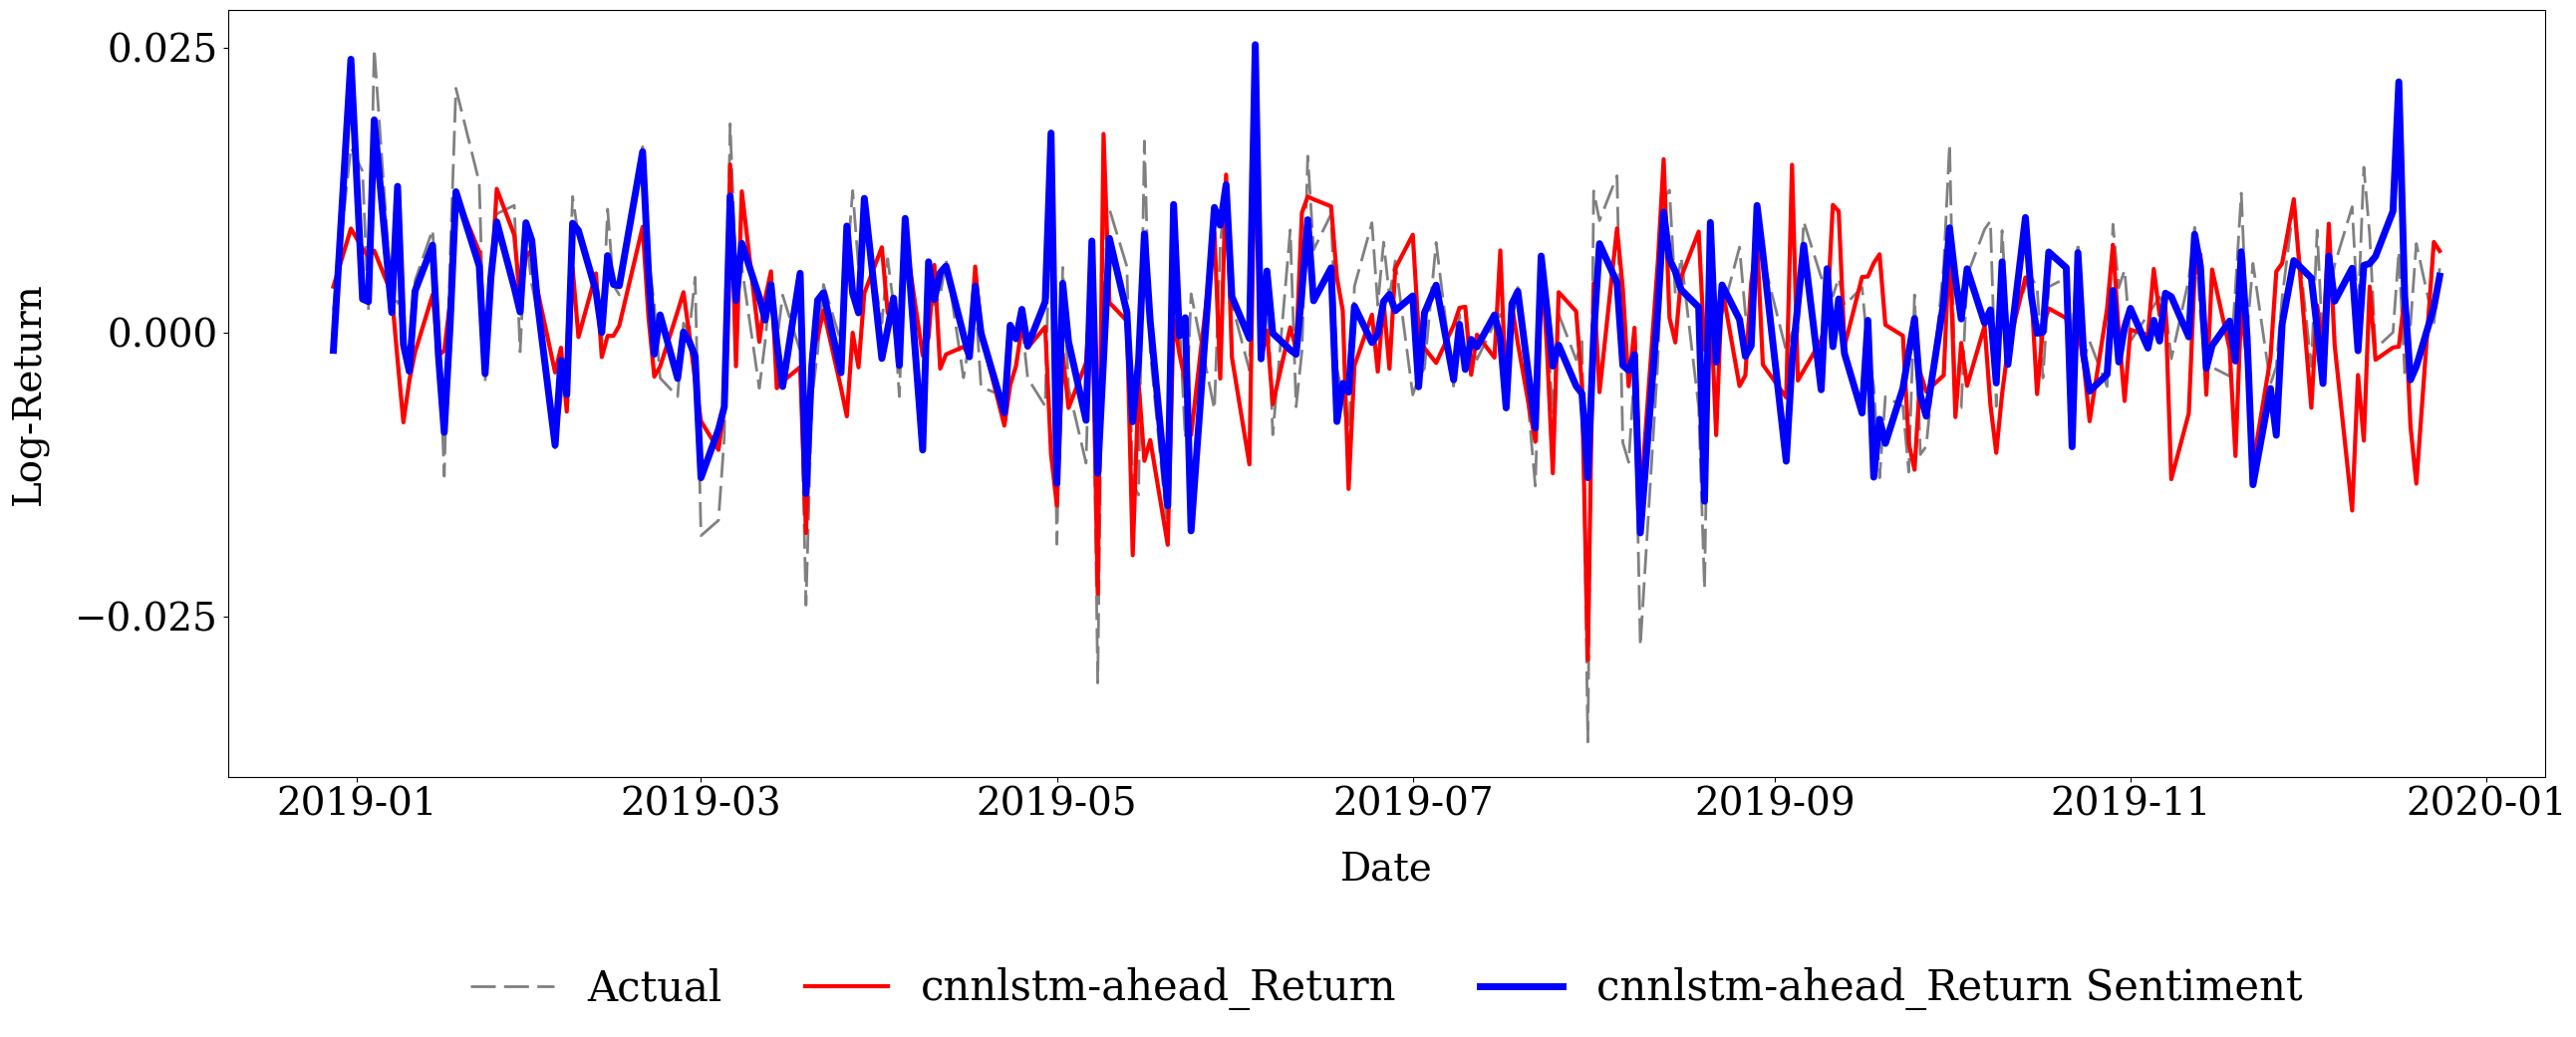

{'file': 'PBD', 'Model': 'cnnlstm-ahead_Return', 'shift': 3, 'RMSE SENT': 0.005789146732723252, 'RMSE': 0.007793516530025084, 'pc': -0.25718426201828826, 'DM MSE': -3.5220567975555874, 'p_value MSE': 0.0005092204857431468}


/home/kali/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 4, 32)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,849 (34.57 KB)

 Trainable params: 8,849 (34.57 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)              │ (None, 4, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,721 (34.07 KB)

 Trainable params: 8,721 (34.07 KB)

 Non-trainable params: 0 (0.00 B)

0 : 1232 1242 1252 1262 1272 1282 1292 1302 1312 1322 1332 1342 1352 1362 1372 1382 1392 1402 1412 1422 1432 1442 1452 1462 1472 model RMSE = 0.020484877433486762
1232 1242 1252 1262 1272 1282 1292 1302 1312 1322 1332 1342 1352 1362 1372 1382 1392 1402 1412 1422 1432 1442 1452 1462 1472 model RMSE = 0.01709318915745224
1 : 1232 1242 1252 1262 1272 1282 1292 1302 1312 1322 1332 1342 1352 1362 1372 1382 1392 1402 1412 1422 1432 1442 1452 1462 1472 model RMSE = 0.014728225572462166
1232 1242 1252 1262 1272 1282 1292 1302 1312 1322 1332 1342 1352 1362 1372 1382 1392 1402 1412 1422 1432 1442 1452 1462 1472 model RMSE = 0.01796186691590188
2 : 1232 1242 1252 1262 1272 1282 1292 1302 1312 1322 1332 1342 1352 1362 1372 1382 1392 1402 1412 1422 1432 1442 1452 1462 1472 model RMSE = 0.012572109888746935
1232 1242 1252 1262 1272 1282 1292 1302 1312 1322 1332 1342 1352 1362 1372 1382 1392 1402 1412 1422 1432 1442 1452 1462 1472 model RMSE = 0.01599097686899519
3 : 1232 1242 1252 1262 1272 1282 129

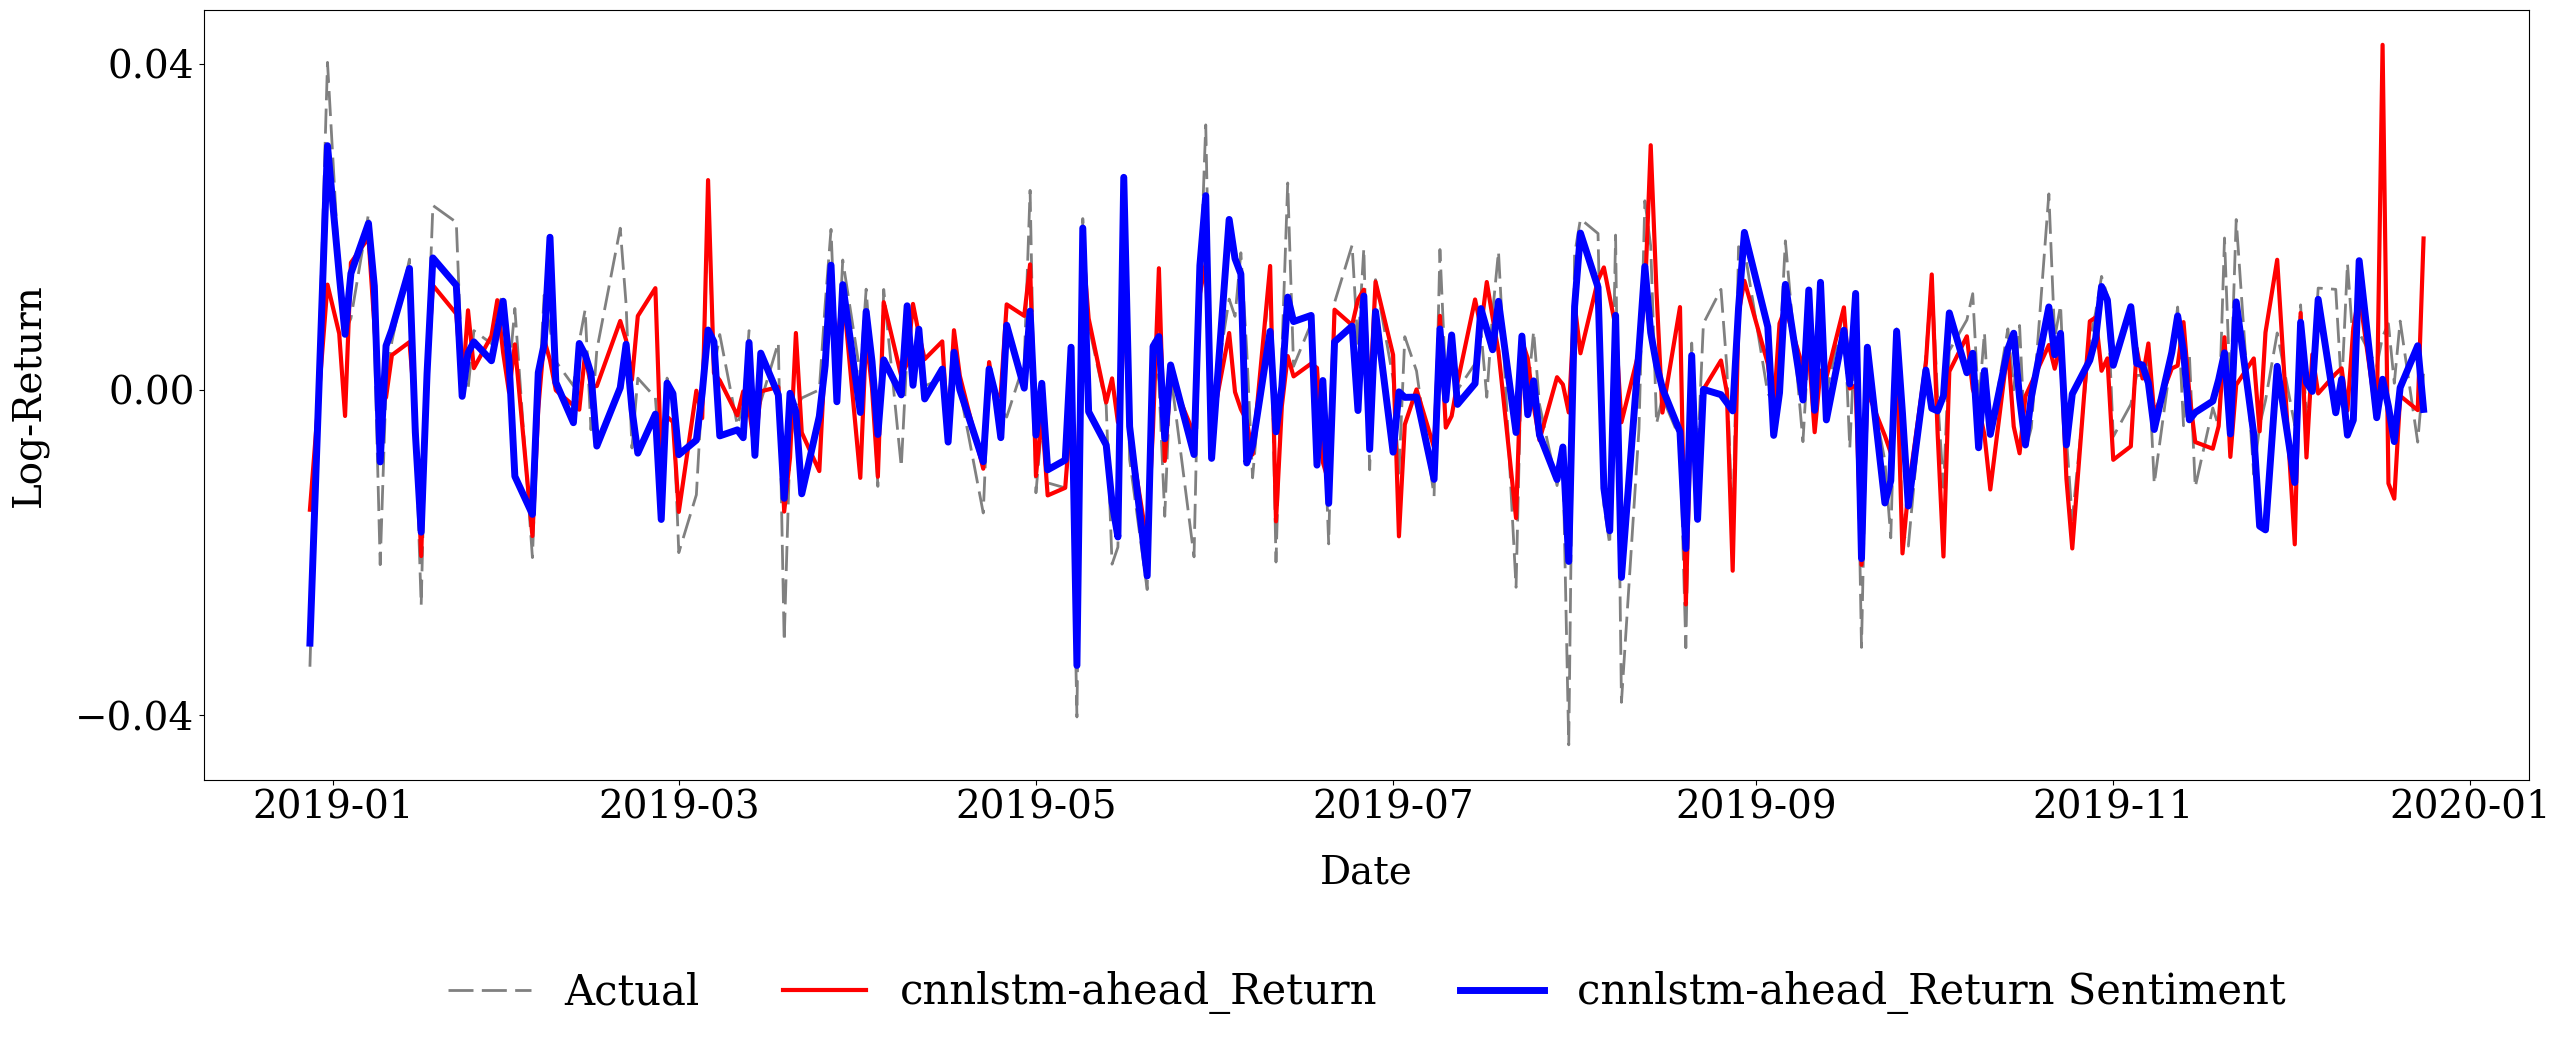

{'file': 'QCLN', 'Model': 'cnnlstm-ahead_Return', 'shift': 3, 'RMSE SENT': 0.00737370716230832, 'RMSE': 0.00956700456560354, 'pc': -0.22925643949003957, 'DM MSE': -2.459709233254194, 'p_value MSE': 0.01458541746943569}


/home/kali/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 4, 32)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,849 (34.57 KB)

 Trainable params: 8,849 (34.57 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_13 (Conv1D)              │ (None, 4, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,721 (34.07 KB)

 Trainable params: 8,721 (34.07 KB)

 Non-trainable params: 0 (0.00 B)

0 : 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 model RMSE = 0.015297262410049138
1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 model RMSE = 0.013404000073480606
1 : 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 model RMSE = 0.013822470954128379
1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 model RMSE = 0.014655227479984536
2 : 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 model RMSE = 0.008831489126087555
1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 model RMSE = 0.012396398363360208
3 : 1230 1240 1250 1260 1270 1280 

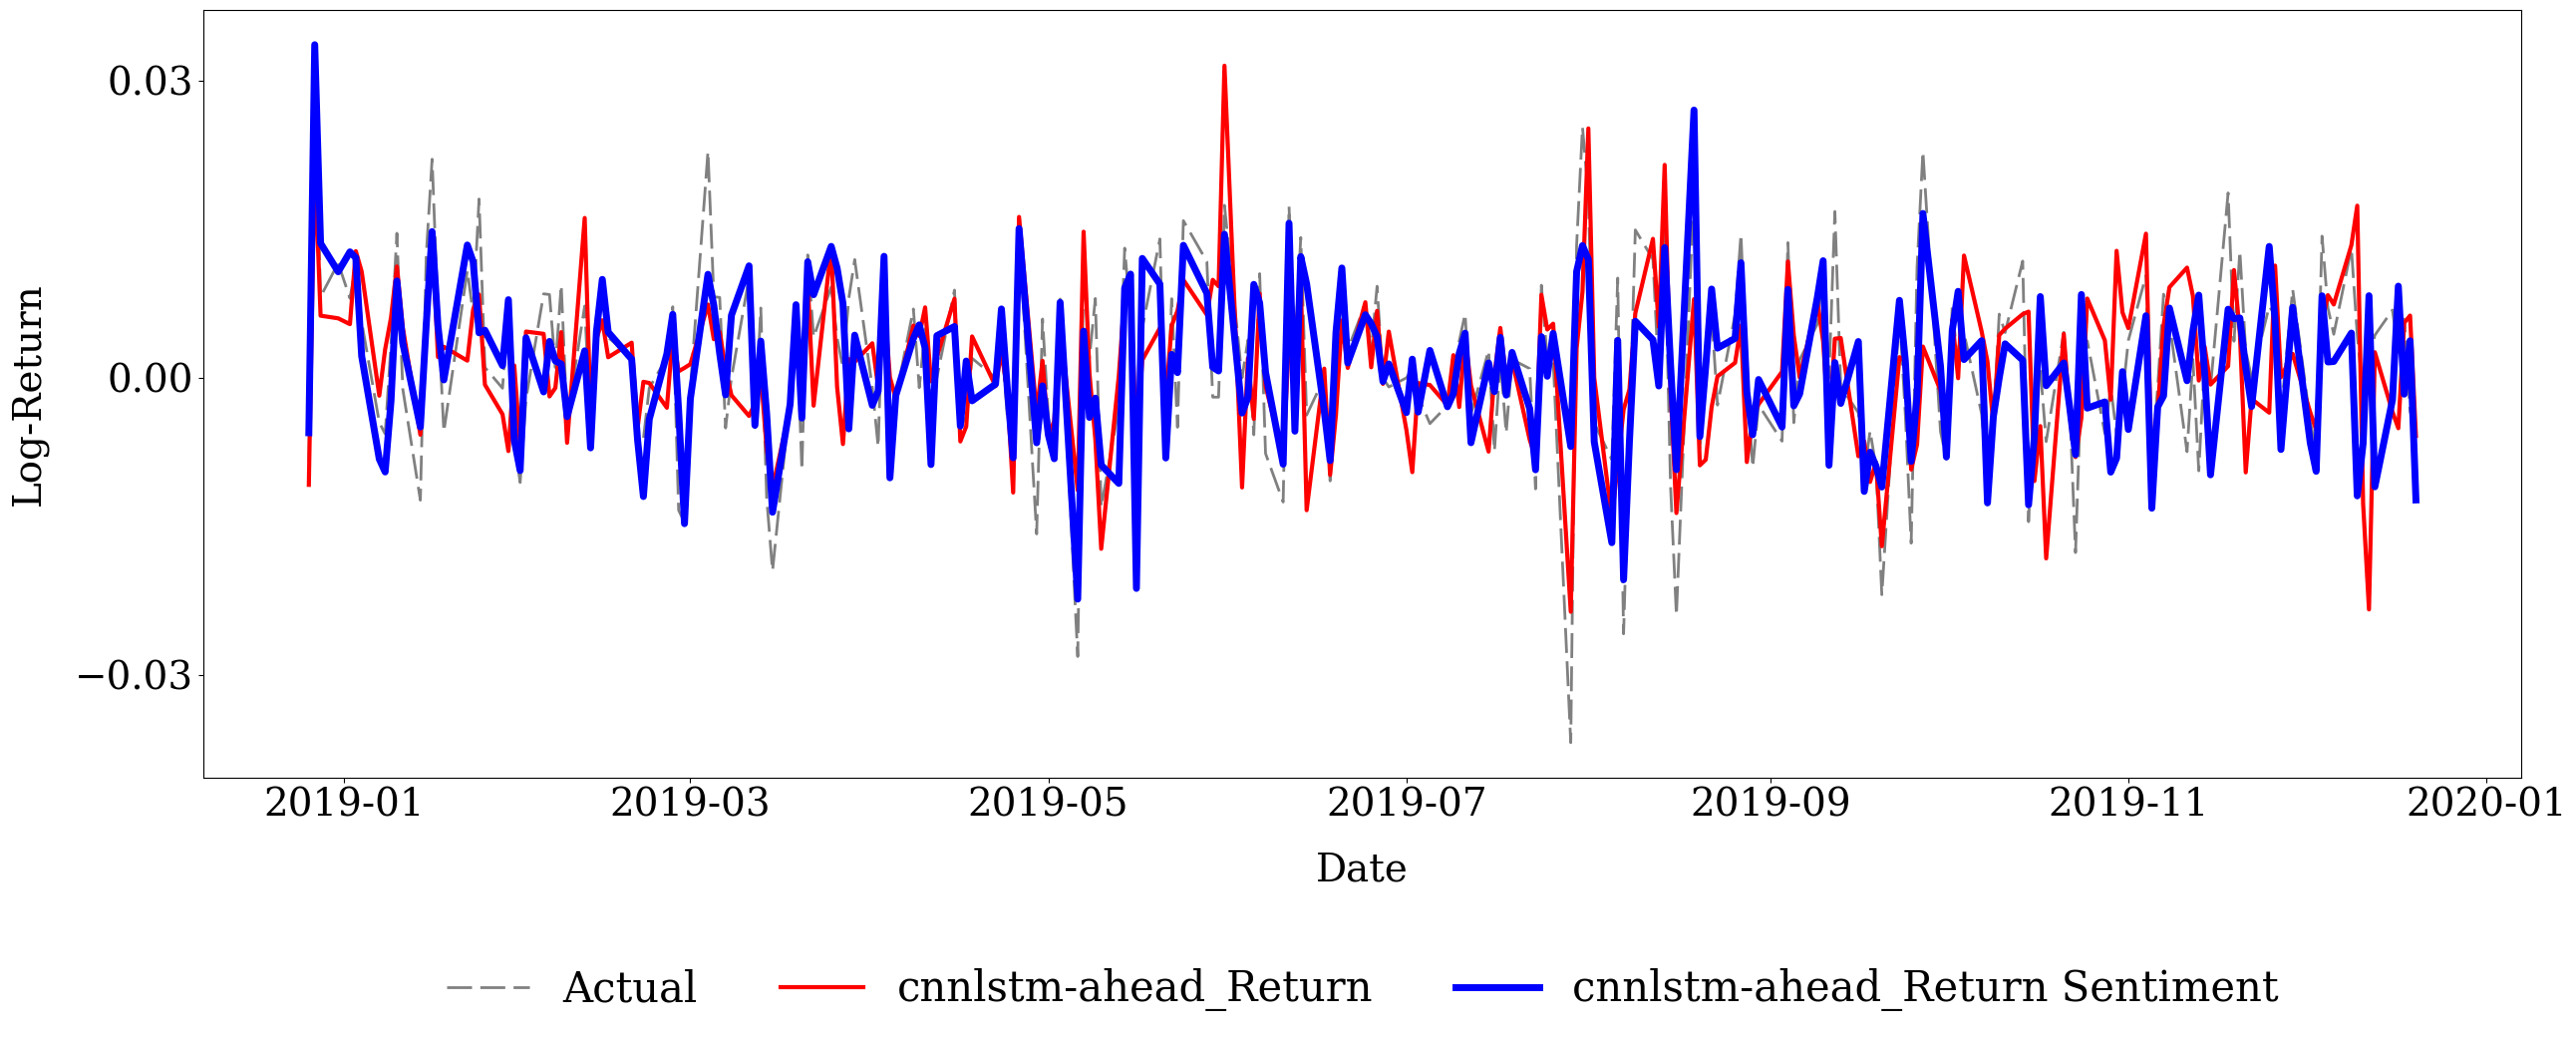

{'file': 'ICLN', 'Model': 'cnnlstm-ahead_Return', 'shift': 5, 'RMSE SENT': 0.0059830316205049345, 'RMSE': 0.007447722617888649, 'pc': -0.19666293611226604, 'DM MSE': -4.445873887125528, 'p_value MSE': 1.3191848726852066e-05}


/home/kali/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 4, 32)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,849 (34.57 KB)

 Trainable params: 8,849 (34.57 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 4, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,721 (34.07 KB)

 Trainable params: 8,721 (34.07 KB)

 Non-trainable params: 0 (0.00 B)

0 : 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 model RMSE = 0.016477099335673602
1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 model RMSE = 0.011405301685972773
1 : 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 model RMSE = 0.009663162068246878
1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 model RMSE = 0.01346271449224135
2 : 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 model RMSE = 0.008045488767035442
1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 model RMSE = 0.012201071355166782
3 : 1230 1240 1250 1260 1270 1280 1

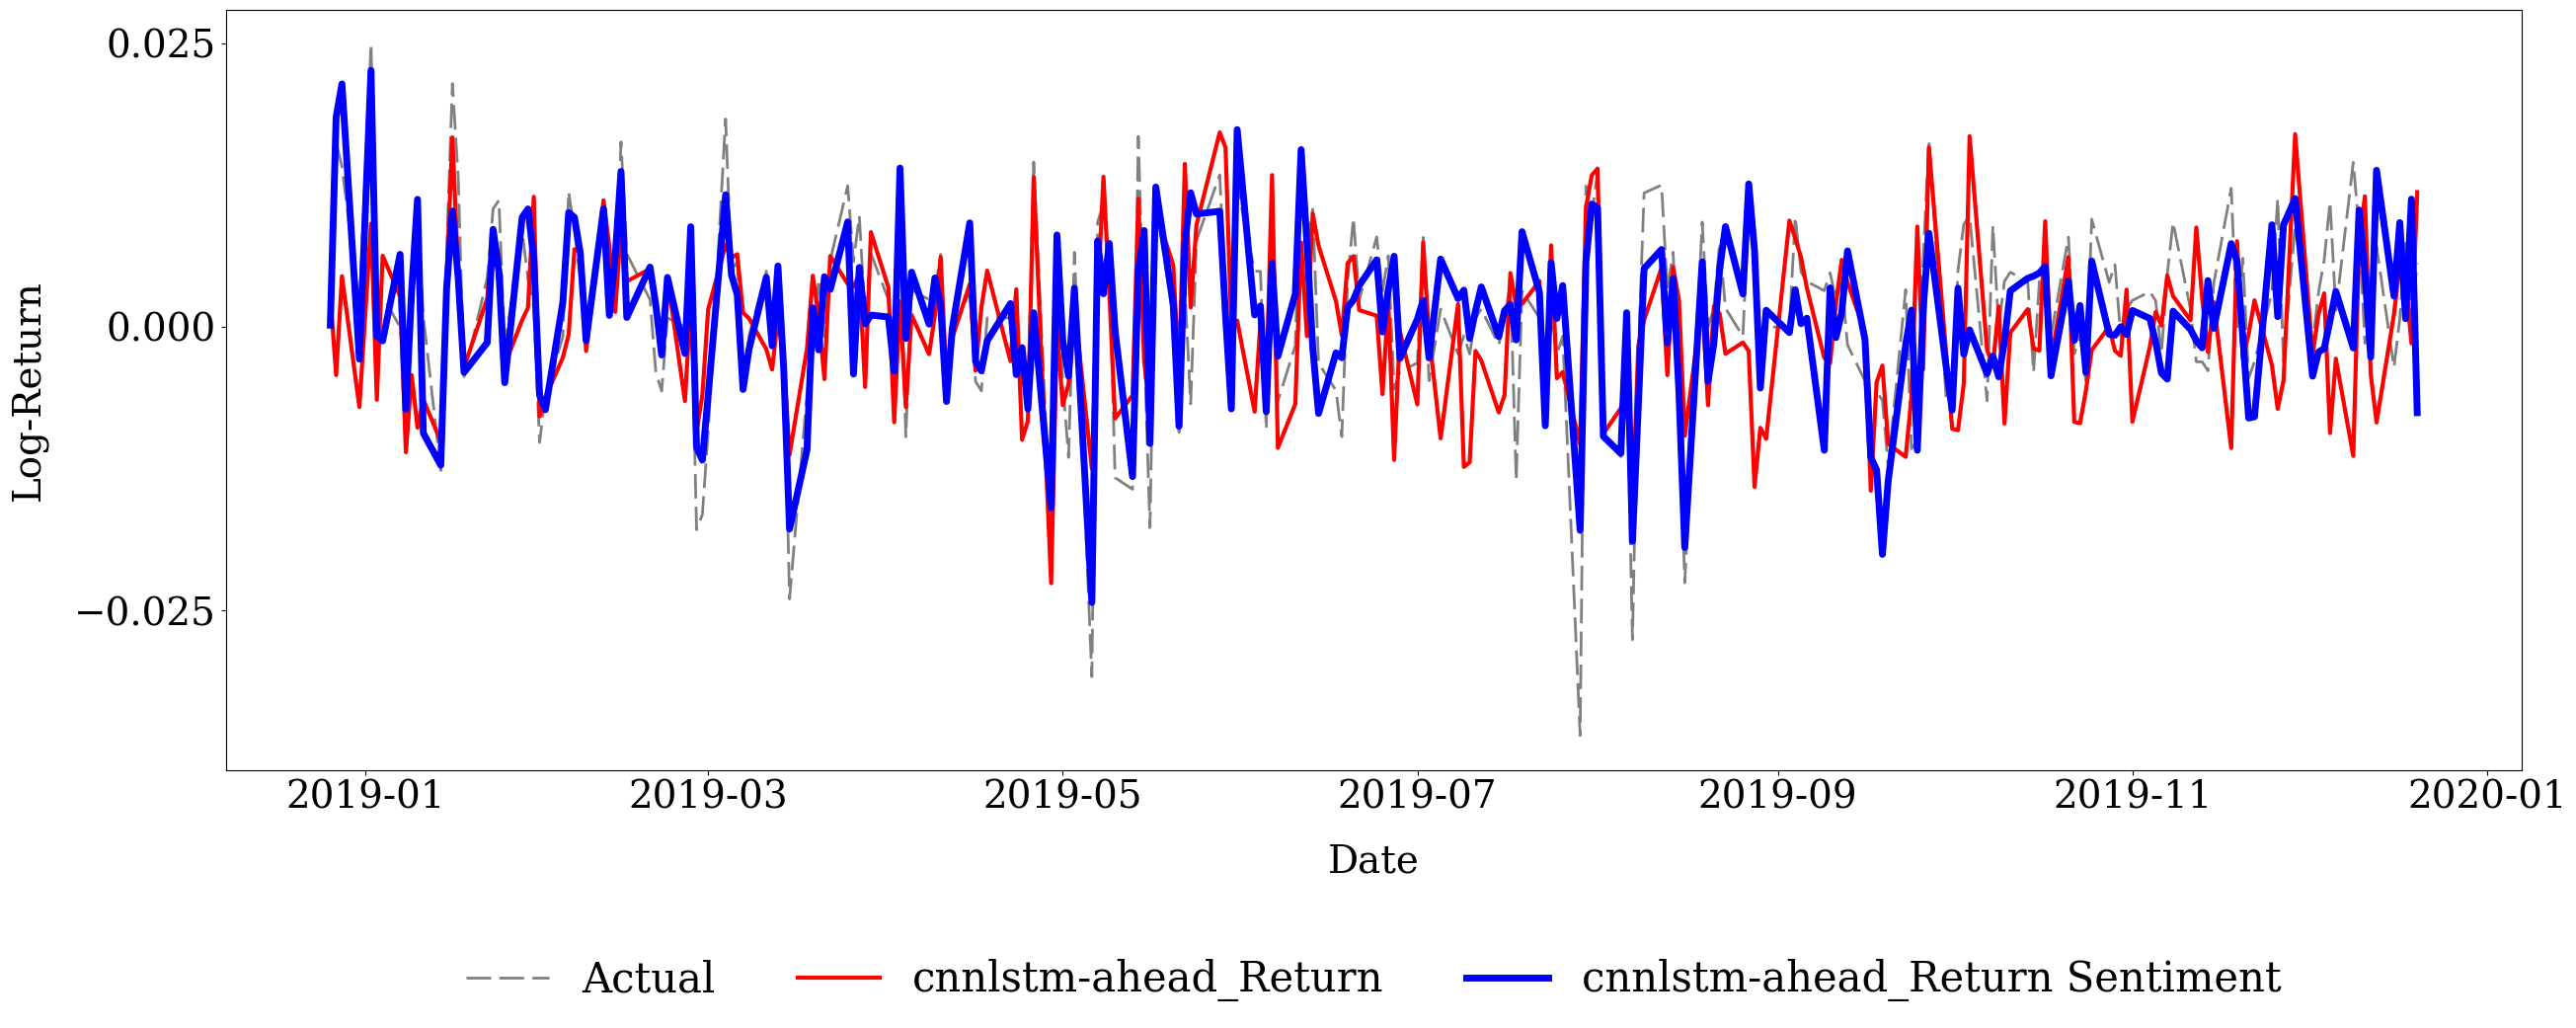

{'file': 'PBD', 'Model': 'cnnlstm-ahead_Return', 'shift': 5, 'RMSE SENT': 0.005509446722589557, 'RMSE': 0.00742150940508497, 'pc': -0.2576379787628284, 'DM MSE': -3.892999190137275, 'p_value MSE': 0.0001272047773537777}


/home/kali/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)              │ (None, 4, 32)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,849 (34.57 KB)

 Trainable params: 8,849 (34.57 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_17 (Conv1D)              │ (None, 4, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,721 (34.07 KB)

 Trainable params: 8,721 (34.07 KB)

 Non-trainable params: 0 (0.00 B)

0 : 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 model RMSE = 0.02039811444522754
1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 model RMSE = 0.018059455814759626
1 : 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 model RMSE = 0.01577674433147781
1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 model RMSE = 0.017357197190836046
2 : 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 model RMSE = 0.013004828033602082
1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 model RMSE = 0.014798204719648586
3 : 1230 1240 1250 1260 1270 1280 12

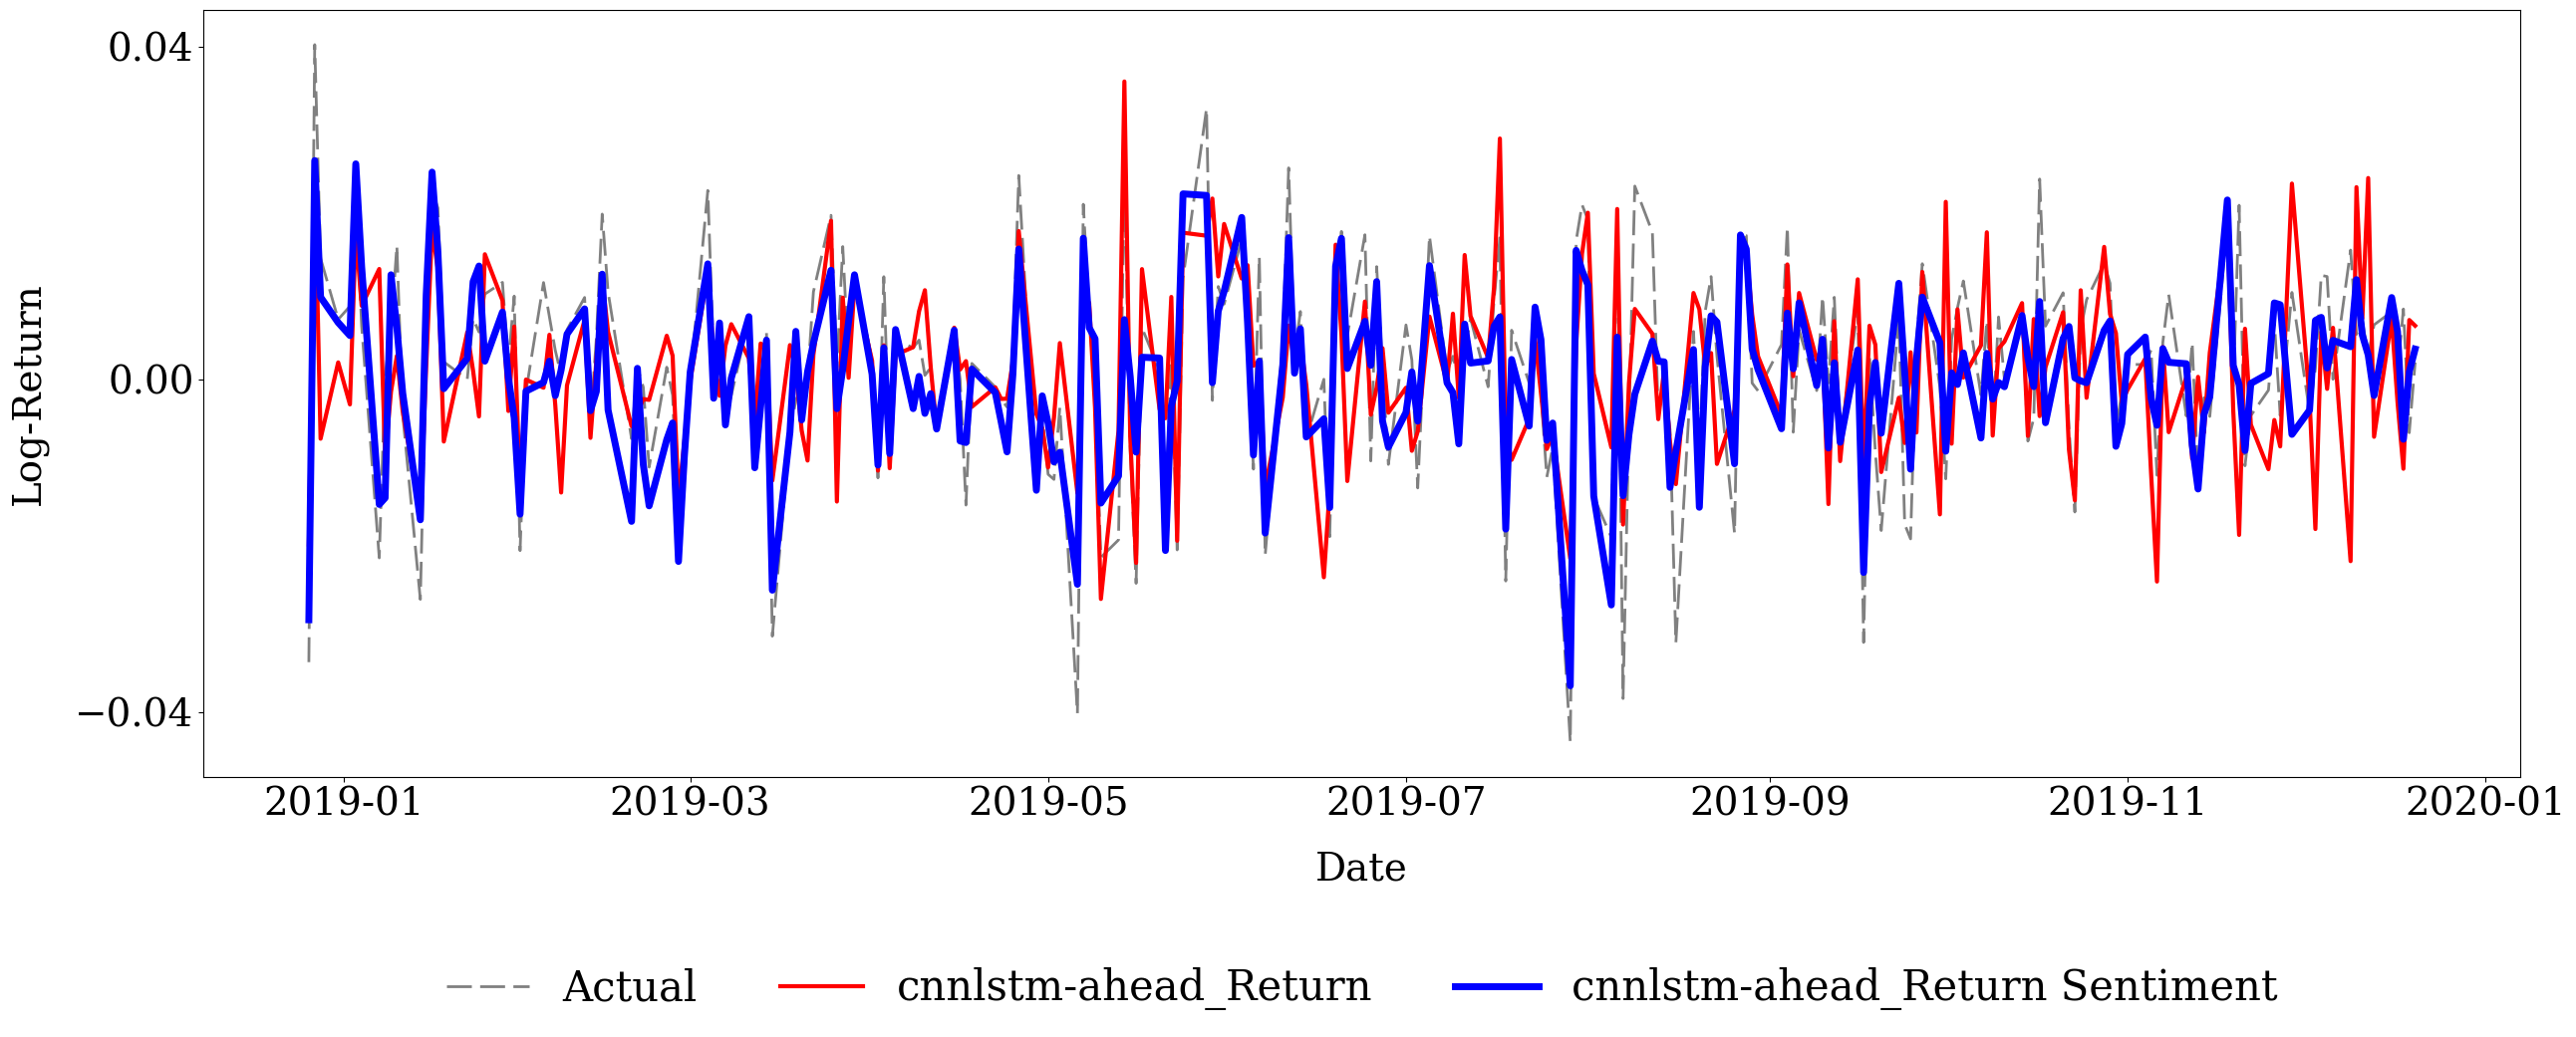

{'file': 'QCLN', 'Model': 'cnnlstm-ahead_Return', 'shift': 5, 'RMSE SENT': 0.007408730462624082, 'RMSE': 0.010431398920800809, 'pc': -0.28976635647107235, 'DM MSE': -3.6562777688234407, 'p_value MSE': 0.00031218282731265847}


In [7]:
for lag in lags : 
    for etf in etfs : 
        generate_result(etf=etf,lag=lag)